In [2]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysam

# Repeat element of SVs

In [2]:
ncell = 350
f_vcf = "../../4_NanoStrandSeq_Phasing/results/HG001_Cell_%d/sv/cutesv.filtered.vcf.gz" % ncell
f_tsv = "results/quant_phased_svs.HG001_Cell_%d.tsv" % ncell
with pysam.VariantFile(f_vcf) as f:
    records = {r.id: r for r in f}
dat = pd.read_csv(f_tsv, sep="\t")
dat = dat[(dat["GenoType"] != ".") & (dat["Length_HP1"] >= 100)]
print("SV numebr (>= 100 bp):", len(dat))

[W::hts_idx_load3] The index file is older than the data file: ../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/sv/cutesv.filtered.vcf.gz.tbi


SV numebr (>= 100 bp): 5828


In [3]:
with open("results/repeat_elements/deletion_insertion_sequences.fasta", "w+") as fw:
    for name in dat["Name_HP1"]:
        record = records[name]
        svtype = record.info["SVTYPE"]
        ref, alt = record.ref, record.alts[0]
        chrom = record.contig
        start = record.start
        end = record.stop
        if svtype == "INS":
            seq = alt[1:]
        elif svtype == "DEL":
            seq = ref[1:]
        else:
            continue
        fw.write(">%s %s:%d-%d\n" % (name, chrom, start, end))
        fw.write("%s\n" % seq)

In [22]:
fasta = "results/repeat_elements/deletion_insertion_sequences.fasta"
outdir = "results/repeat_elements/deletion_insertion_sequences_rmsk"
log = "results/repeat_elements/deletion_insertion_sequences_rmsk.log"
cmd = "RepeatMasker -pa 24 -species human -poly -html -gff -dir %s %s > %s" % (outdir, fasta, log)
print(cmd)
if not os.path.exists(outdir):
    ! source ~/miniconda3/bin/activate repeatmasker && {cmd}

In [26]:
out = "results/repeat_elements/deletion_insertion_sequences_rmsk/deletion_insertion_sequences.fasta.out"
data = defaultdict(list)
with open(out) as f:
    for line in f.readlines()[3:]:
        row = line.split()
        if row[8] == "+":
            begin, end, left = int(row[11]), int(row[12]), int(row[13][1:-1])
        elif row[8] == "C":
            left, end, begin = int(row[11][1:-1]), int(row[12]), int(row[13])
        element_length = end + left
        ratio = (end - begin) / element_length
        #if ratio < 0.9:
            #continue
        #if left > 10 or begin > 10:
        #    continue
        name = row[10]
        if name == "Unknown":
            continue
        if name.startswith("LINE") or name.startswith("SINE") or name.startswith("LTR") or name.startswith("Satellite"): #  or name.startswith("DNA"):
            data[row[4]].append(row[10])

In [27]:
len(data), len(dat)

(3628, 5828)

In [28]:
def counting(elements):
    line = 0
    sine = 0
    ltr = 0
    tandem_repeat = 0
    for e in elements:
        if e.startswith("LINE"):
            line += 1
        if e.startswith("SINE"):
            sine += 1
        if e.startswith("LTR"):
            ltr += 1
        if e.startswith("Satellite"):
            tandem_repeat += 1
    return line, ltr, sine, tandem_repeat

with_element = 0
counts = np.zeros(5) # 
counter = defaultdict(int) #

for name, elements in data.items():
    if len(elements) == 0:
        continue
    
    line, ltr, sine, tandem_repeat = counting(elements)
    if line + ltr + sine + tandem_repeat > 0:
        with_element += 1
    
    ss = []
    if line > 0:
        ss.append("%d LINE" % line)
    if ltr > 0:
        ss.append("%d LTR" % ltr)
    if sine > 0:
        ss.append("%d SINE" % sine)
    if tandem_repeat > 0:
        ss.append("%d Tandem repeat" % tandem_repeat)
    s = " + ".join(ss)
    
    if len(elements) > 1:
        counter[s] += 1
        
    if len(elements) == 1:
        if line == 1:
            counts[0] += 1
        elif ltr == 1:
            counts[1] += 1
        elif sine == 1:
            counts[2] += 1
        elif tandem_repeat == 1:
            counts[3] += 1
        else:
            pass
            # counts[5] += 1
    else:
        counts[4] += 1

In [29]:
print(counts)
ratios = counts * 100 / sum(counts)
print(ratios)

[ 359.  163. 2530.   62.  514.]
[ 9.8952591   4.49283352 69.7353914   1.70893054 14.16758545]


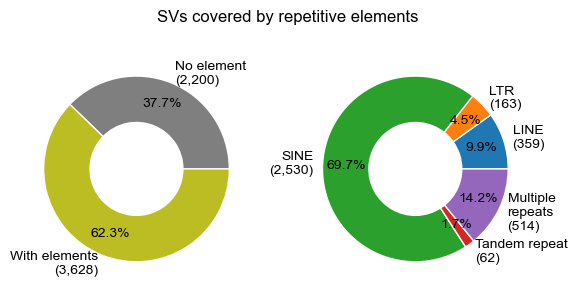

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(6 ,3))

plt.suptitle("SVs covered by repetitive elements")

plt.sca(axs[0])
no_element = len(dat) - with_element
labels = ["No element\n(%s)" % format(no_element, ","), "With elements\n(%s)" % format(with_element, ",")]
plt.pie([no_element, with_element], 
        colors=["C7", "C8"], 
        pctdistance=0.75,
        autopct="%.1f%%",
        wedgeprops=dict(width=0.5, edgecolor='w'), 
        labels=labels)

plt.sca(axs[1])
labels = ["LINE", "LTR", "SINE", "Tandem repeat", "Multiple\nrepeats"]
for i in range(len(labels)):
    labels[i] = "%s\n(%s)" % (labels[i], format(int(counts[i]), ","))
wedges, texts, autotexts = plt.pie(
    counts, 
    autopct="%.1f%%", 
    pctdistance=0.75, 
    colors=["C0", "C1", "C2", "C3", "C4"],
    wedgeprops=dict(width=0.5, edgecolor='w'),
    labels=labels)

plt.tight_layout()
plt.savefig("figures/repeat_element_cover_sv.pdf", dpi=300)

# SV recovered by BGISEQ500

In [21]:
out = "results/repeat_elements/deletion_insertion_sequences_rmsk/deletion_insertion_sequences.fasta.out"
data = defaultdict(list)
with open(out) as f:
    for line in f.readlines()[3:]:
        row = line.split()
        if row[8] == "+":
            begin, end, left = int(row[11]), int(row[12]), int(row[13][1:-1])
        elif row[8] == "C":
            left, end, begin = int(row[11][1:-1]), int(row[12]), int(row[13])
        element_length = end + left
        ratio = (end - begin) / element_length
        #if ratio < 0.9:
            #continue
        #if left > 10 or begin > 10:
        #    continue
        name = row[10]
        if name == "Unknown":
            continue
        if name.startswith("LINE") or name.startswith("SINE") or name.startswith("LTR") or name.startswith("Satellite"): #  or name.startswith("DNA"):
            data[row[4]].append(row[10])

d = pd.read_csv("results/quant_phased_svs.HG001_Cell_350.tsv", sep="\t")
d.index = d["Name_HP1"]
d.index.name = "Name"
d = d[(d["GenoType"] != ".") & (d["Length_HP1"] >= 100)]

vs = []
for name in d.index:
    vs.append(",".join(data[name]))
d["RepeatElement"] = vs

In [24]:
from collections import Counter